This notebook's goal is to interpret and explain a CNN that classifies signals whether they are pure or peturbed by a gaussian white noise. 

In [87]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import keras
import numpy as np
import cv2
import tensorflow as tf
import scipy.signal
import scipy.io
import scipy.fft
import shap

from keras.applications.resnet import ResNet101
from lime import lime_image, lime_tabular
from keras.utils import img_to_array
from sklearn.metrics import classification_report
from skimage.segmentation import mark_boundaries
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Input, BatchNormalization, Conv1D, MaxPooling1D
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling2D, Concatenate

tf.compat.v1.disable_eager_execution()


Generation of pure / perturbed signals
--------------------------------------

In [88]:
# Number of signals
n_sig = 500
# Number of sampling points for each signal
n_samp = 250
# Sampling frequency
f_samp = 250
# Signal max frequency
f_max = 12
# Time vector
time = np.linspace(0, n_samp/f_samp, n_samp)

In [89]:
# num_signals : number of "signals" images we want to generate
# add_noise : True if we want to add white noise to the signal
# padding : space we want to leave free at top 
#           and bottom of the signal inside the image
# img_size : width = number of sample of the signal, sampled at 100 Hz

def generate_img_sig(num_signals:int, add_noise:bool = False, padding:int = 25, 
                   img_size:tuple = (250, 250)):
    num_samples = img_size[1]
    height = img_size[0]
    f_high = (4*f_samp) / num_samples      # Highest frequency for 2 period per signal
    f_low = (1*f_samp) / num_samples
    df = (f_high - f_low) / (num_signals/10)    # frequency step for 1 signals per frequency
    t = np.linspace(0, num_samples/f_samp, num_samples)
    img_ds = np.zeros((num_signals, height, num_samples, 3))
    sig_ds = np.zeros((num_signals, num_samples))

    for i in range(num_signals):
        f = f_low + (i//10)*df      # Increasing frequency every 10 signals
        phi = 2*np.pi*(i%10)/10     # Increasing phase for each signals
        sig = np.sin(2*np.pi*f*t + phi)
        if add_noise:               # Noise added with Matlab
            A = 0.2 + 2*(i%10)/100
            noise = A*np.random.normal(0, 1, num_samples)
            sig += noise
        img = sig_to_img(sig, padding, img_size)
        img_ds[i] = img
        sig_ds[i, :] = sig

    return (img_ds, sig_ds)


# signal : signal we want to transform into image
# padding : space we want to leave free at top 
#           and bottom of the signal inside the image
# img_size : width is the number of samples constituting each signal

def sig_to_img(signal:np.array, padding:int = 25, img_size:int = (250, 250)):
    height = img_size[0]
    num_samples = img_size[1]
    offset = height // 2
    row_high = height - padding
    middle = (row_high - padding) // 2
    img = np.zeros(img_size) + 255
    last_row = offset
    for i in range(num_samples):
        row = int(offset - (signal[i] * middle))
        if row >= height:
            row = height - 1
        elif row < 0:
            row = 0
        if last_row < row:
            img[last_row:row, i] = 0
        elif last_row > row:
            img[row:last_row, i] = 0
        else:
            img[row, i] = 0
        last_row = row
    img = cv2.cvtColor(np.expand_dims(img, -1).astype("float32"), cv2.COLOR_GRAY2RGB)

    return img
    

In [90]:
# # Not used. We use a dedicated Matlab function to perturbe signals (agwn).
# # Dataset of pure signals
# pure_img, pure_sig = generate_img_sig(n_sig)

# # Dataset of perturbed signals
# pert_img, pert_sig = generate_img_sig(n_sig, add_noise = True)

# # Saving signals for Matlab manipulation
# scipy.io.savemat("pure_sig.mat", {"pure_sig":pure_sig})
# scipy.io.savemat("pert_sig.mat", {"pert_sig":pert_sig})

In [91]:
# UNCOMMENT IF YOU WANT TO CREATE NEW SIGNALS

# Dataset of pure signals
pure_img, pure_sig = generate_img_sig(n_sig)

# Saving for Matlab manipulation
scipy.io.savemat("pure_sig.mat", {"pure_sig":pure_sig})

Each cell below create a different kind of dataset depending on the type of network used for classification, or the nature of the signals. __Uncomment only the desired cell.__   
__1__: Temporal signals (1D). Meant to be used with 1D CNN.   
__2__: Wavelet transforms of temporal signals created with Matlab (2D). Meant to be used with 2D CNN. You need to create perturbed signals on Matlab using ''add_noise'' function and compute wavelet transforms with cwt function.   
__3__: Wavelet transforms of temporal signals created with scipy module on Python (2D). Meant to be used with 2D CNN.

In [92]:
# # 1
# # Dataset of signals for 1D CNN model

# pert_sig = scipy.io.loadmat("pert_sig.mat")
# pert_sig = pert_sig["pert_sig"]

# pert_img = np.array([sig_to_img(s) for s in pert_sig])

# pure = np.expand_dims(pure_sig, -1)
# pert = np.expand_dims(pert_sig, -1)

In [121]:
# 2
# COMPUTE pert_sig AND pure_cwt AND pert_cwt ON MATLAB BEFORE LOADING
# Loading signals from Matlab

# SEE MATLAB FOR SCALES SETTING WHEN COMPUTING CWT

pert_sig = scipy.io.loadmat("pert_sig.mat")
pert_sig = pert_sig["pert_sig"]

# Loading pure and perturbated cwt from matlab

pure_cwt = scipy.io.loadmat("pure_cwt.mat")
pure_cwt = pure_cwt["pure_cwt"][0]
pert_cwt = scipy.io.loadmat("pert_cwt.mat")
pert_cwt = pert_cwt["pert_cwt"][0]

# Datasets of cwt from Matlab

pu_cwt = np.zeros((pure_cwt.shape[0], pure_cwt[0].shape[0], pure_cwt[0].shape[1], 3))
pe_cwt = np.zeros((pert_cwt.shape[0], pert_cwt[0].shape[0], pert_cwt[0].shape[1], 3))

for i in range(pu_cwt.shape[0]):
    pu_cwt[i, :, :, 0] = np.real(pure_cwt[i]).astype("float32")
    pu_cwt[i, :, :, 1] = np.real(pure_cwt[i]).astype("float32")
    pu_cwt[i, :, :, 2] = np.real(pure_cwt[i]).astype("float32")    
    # pu_cwt[i, :, :, 2] = np.imag(pure_cwt[i]).astype("float32")
    pu_cwt[i] = 15 * np.flipud(pu_cwt[i])

for i in range(pe_cwt.shape[0]):
    pe_cwt[i, :, :, 0] = np.real(pert_cwt[i]).astype("float32")
    pe_cwt[i, :, :, 1] = np.real(pert_cwt[i]).astype("float32")
    pe_cwt[i, :, :, 2] = np.real(pert_cwt[i]).astype("float32")
    # pe_cwt[i, :, :, 2] = np.imag(pert_cwt[i]).astype("float32")
    pe_cwt[i] = 15 * np.flipud(pe_cwt[i])

pure = np.array([cv2.resize(im, (120, 120)) for im in pu_cwt]).astype("float32")
pert = np.array([cv2.resize(im, (120, 120)) for im in pe_cwt]).astype("float32")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


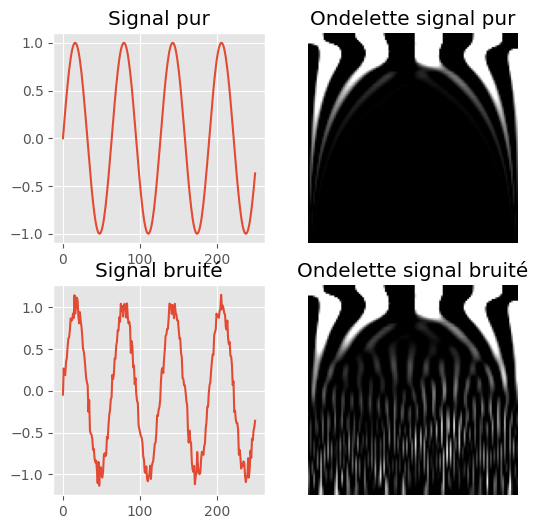

In [122]:
fig, axs = plt.subplots(2, 2, figsize = (6, 6))
axs[0, 0].plot(pure_sig[490])
axs[0, 0].set_title("Signal pur")
axs[0, 1].imshow(pure[490])
axs[0, 1].set_title("Ondelette signal pur")
axs[0, 1].axis("off")
axs[0, 1].grid("off")

axs[1, 0].plot(pert_sig[490])
axs[1, 0].set_title("Signal bruité")
axs[1, 1].imshow(pert[490])
axs[1, 1].set_title("Ondelette signal bruité")
axs[1, 1].axis("off")
axs[1, 1].grid("off")

In [123]:
# # 3
# # Datasets of cwt (4D)

# pu_cwt = np.zeros((n_sig, pure_sig.shape[1], pure_sig.shape[1], 2))
# for i in range(len(pure_sig)):
#     cwt = scipy.signal.cwt(pure_sig[i], scipy.signal.morlet2, np.arange(1, n_samp+1))
#     pu_cwt[i, :, :, 0] = np.real(cwt)
#     pu_cwt[i, :, :, 1] = np.imag(cwt)

# pe_cwt = np.zeros((n_sig, pert_sig.shape[1], pert_sig.shape[1], 2))
# for i in range(len(pert_sig)):
#     cwt = scipy.signal.cwt(pert_sig[i], scipy.signal.morlet2, np.arange(1, n_samp+1))
#     pe_cwt[i, :, :, 0] = np.real(cwt)
#     pe_cwt[i, :, :, 1] = np.imag(cwt)

In [124]:
# Full datasets
x = np.concatenate([pure, pert], axis = 0)
y = np.zeros((x.shape[0], 2))
y[pure.shape[0]:, 1] = 1

In [125]:
# Training datasets
x_train, x_val_test, y_train, y_val_test = train_test_split(
    x, y, test_size = 0.2, random_state = 42)

In [126]:
# Validation and testing datasets
x_val, x_test, y_val, y_test = train_test_split(
    x_val_test, y_val_test, test_size = 0.5, random_state = 42)

CNN design and training
-----------------------

2D CNN network

In [127]:
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

model = Sequential(name = "CWT_CNN")

model.add(Conv2D(8, (5, 5), input_shape = input_shape,
                 activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3)))

model.add(Dropout(rate = 0.3))
model.add(Flatten())
model.add(Dense(2, activation = "softmax"))

# Compilation of model
model.compile(loss = "categorical_crossentropy",
        optimizer = keras.optimizers.Adam(learning_rate = 1e-3), 
        metrics = ["accuracy"])
model.summary()

Model: "CWT_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 116, 116, 8)       608       
                                                                 
 batch_normalization_5 (Batc  (None, 116, 116, 8)      32        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 38, 38, 8)        0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 38, 38, 8)         0         
                                                                 
 flatten_5 (Flatten)         (None, 11552)             0         
                                                                 
 dense_5 (Dense)             (None, 2)                 2310

1D CNN network

In [129]:
# input_shape = (x_train.shape[1], x_train.shape[2])

# model = Sequential()

# model.add(Conv1D(filters = 12, kernel_size = 7,
#                  input_shape = input_shape,
#                  activation = "relu", padding = "same"))
# model.add(Conv1D(filters = 64, kernel_size = 5,
#                  activation = "relu", padding = "same"))
# model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size = 5))

# model.add(Dropout(rate = 0.3))

# model.add(Flatten())
# model.add(Dense(units = 2, activation = "softmax"))

# # Compilation of model
# model.compile(loss = "categorical_crossentropy",
#         optimizer = keras.optimizers.Adam(learning_rate = 0.01), 
#         metrics = ["accuracy"])
# model.summary()

100 % accuracy for validation and testing, fitting on 5 epochs minimum (1D CNN)

In [130]:
# Fitting model
epochs = 3
H = model.fit(x_train, y_train, 
        validation_data = (x_val, y_val), epochs = epochs)

Train on 800 samples, validate on 100 samples
Epoch 1/3
800/800 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.7837

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


800/800 [==============================] - 10s 12ms/sample - loss: 0.0476 - accuracy: 0.7837 - val_loss: 0.0461 - val_accuracy: 0.7800
Epoch 2/3
800/800 [==============================] - 12s 15ms/sample - loss: 0.0043 - accuracy: 0.7975 - val_loss: 0.0655 - val_accuracy: 0.8600
Epoch 3/3
800/800 [==============================] - 9s 12ms/sample - loss: 0.0070 - accuracy: 0.7900 - val_loss: 0.0856 - val_accuracy: 0.6700


In [131]:
inp = model.input
out = [model.layers[i].output for i in range(3)]

m = Model(inputs = inp, outputs = out)
cwt = np.expand_dims(pert[0], 0)
conv, bn, pool = m.predict(cwt)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


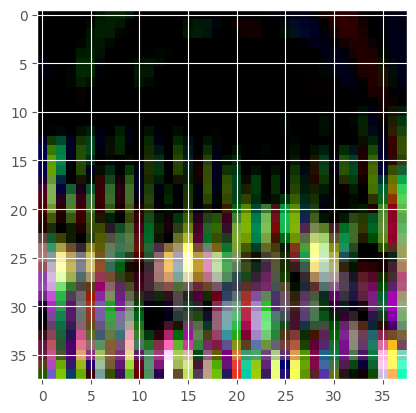

In [132]:
plt.imshow(pool[0, :, :, :3])

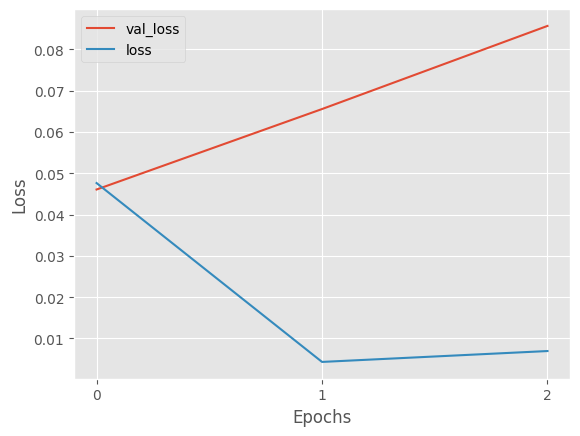

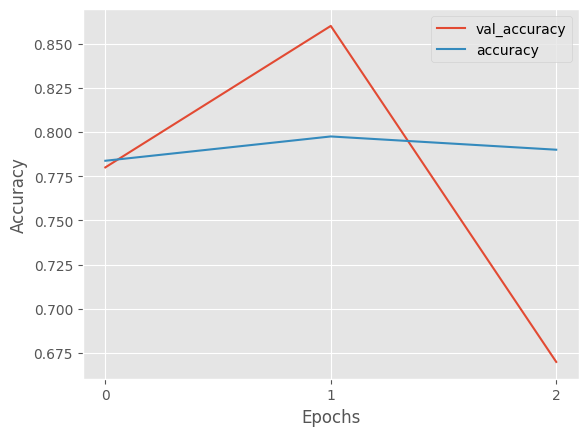

In [133]:
plt.figure()
plt.style.use("ggplot")
plt.plot(H.history["val_loss"], label = "val_loss")
plt.plot(H.history["loss"], label = "loss")
plt.xticks(range(0, epochs))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.style.use("ggplot")
plt.plot(H.history["val_accuracy"], label = "val_accuracy")
plt.plot(H.history["accuracy"], label = "accuracy")
plt.xticks(range(0, epochs))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [134]:
# Predicting
y_pred = model.predict(x_test)
class_names = ["pure", "perturbed"]
print(classification_report(y_test.argmax(1), y_pred.argmax(1),
                            target_names = class_names))

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


              precision    recall  f1-score   support

        pure       1.00      0.19      0.31        54
   perturbed       0.51      1.00      0.68        46

    accuracy                           0.56       100
   macro avg       0.76      0.59      0.49       100
weighted avg       0.78      0.56      0.48       100



Model interpretability
----------------------

1D CNN

In [135]:
# explainer = lime_tabular.RecurrentTabularExplainer(training_data = x_train, 
#                 mode = "classification", feature_names = ["val"], class_names = class_names)

In [136]:
# sig = pert[0]
# exp = explainer.explain_instance(sig, model.predict, top_labels = 2, 
#                         num_features = 15, num_samples = 100)

In [137]:
# def show_exp_1D(exp, sig):
#     img = sig_to_img(sig)
#     m = [exp.as_map()[key] for key in exp.as_map()][0]
#     for i in range(len(m)):
#         pix = m[i][0]
#         val = m[i][1]
#         for p in range(img.shape[0]):
#             if img[p, pix, 0] != 255:
#                 img[p, pix, 0] = 125
#     plt.imshow(img)
#     plt.axis("off")
#     plt.show()
#     return

In [138]:
# show_exp_1D(exp, sig)

2D CNN

In [139]:
def show_exp(exp, top_labels, hide_bg = False, weight = 0, show_pos = False, class_name = None):

    img, mask = exp.get_image_and_mask(top_labels, positive_only = show_pos, 
                    hide_rest = hide_bg, min_weight = weight)
    plt.imshow(mark_boundaries(img, mask))
    plt.axis("off")
    if class_name is not None:
        plt.title(f"Predicted: {class_name}")
    plt.show()

In [140]:
# explainer = lime_image.LimeImageExplainer()

# exp = explainer.explain_instance(pert[0], model.predict, top_labels = 2, num_features = 10,
#                                  hide_color = 0, num_samples = 500)

In [141]:
# for label in exp.top_labels:
#     show_exp(exp, label, hide_bg = True, show_pos = True,
#                 class_name = class_names[label])

In [142]:
reduced_x_train = x_train[np.random.choice(x_train.shape[0], 100, replace = False)]

test_set = np.array([pure[100], pure[499], pert[100], pert[499]])
truth = np.zeros((test_set.shape[0], 2))
truth[2:, 1] = 1

In [143]:
pred_test = model.predict(test_set)
print(classification_report(truth.argmax(axis = 1),
        pred_test.argmax(axis = 1), target_names = class_names))

              precision    recall  f1-score   support

        pure       1.00      1.00      1.00         2
   perturbed       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [144]:
# More precise with x_train, but computation time is much longer
# shap_explainer = shap.DeepExplainer(model, reduced_x_train)
shap_explainer = shap.DeepExplainer(model, x_train)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


__Use DeepExplainer to get coherent explaination.__   
GradientExplainer gives hardly understandable results.

In [156]:
values = shap_explainer.shap_values(test_set)
values[0] = values[0]*10
values[1] = values[1]*10

In [157]:
class_labels = np.array([class_names for i in range(len(values[0]))])
true_labels = [f"pure, pred: {class_names[pred_test[0].argmax()]}({pred_test[0].astype('half')})",
                f"pure, pred: {class_names[pred_test[1].argmax()]}({pred_test[1].astype('half')})", 
                f"perturbed, pred: {class_names[pred_test[2].argmax()]}({pred_test[2].astype('half')})",
                f"perturbed, pred: {class_names[pred_test[3].argmax()]}({pred_test[3].astype('half')})"]
# print(class_labels, "\n", true_labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


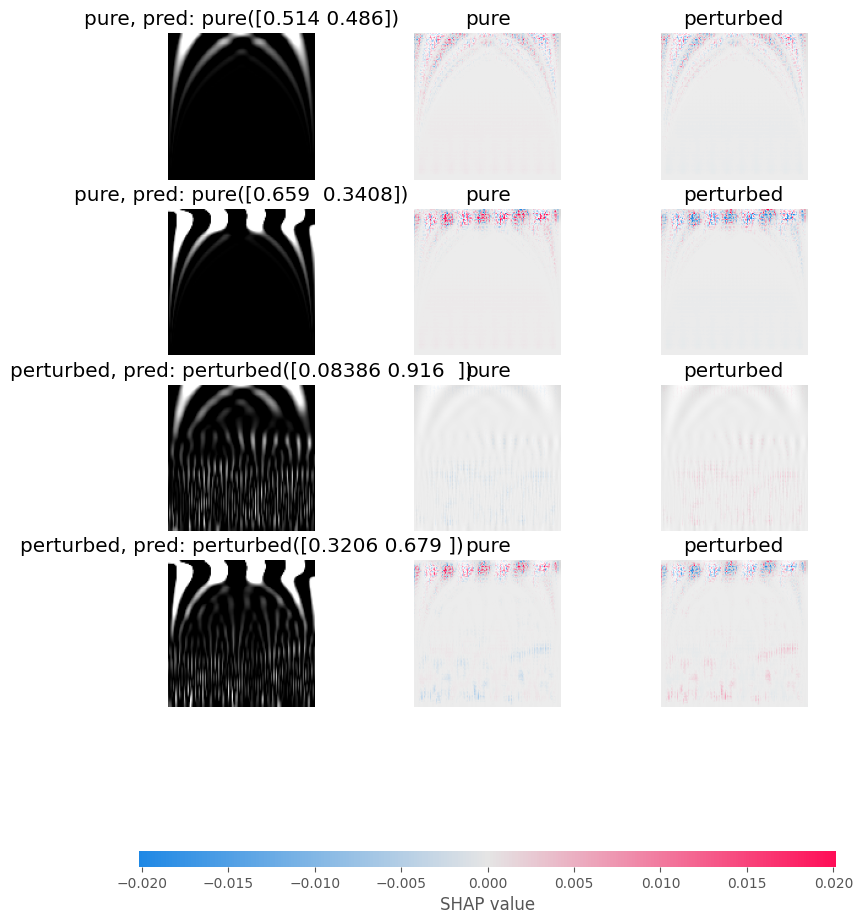

In [158]:
shap.plots.image(values, test_set, labels = class_labels, true_labels = true_labels)

Behavior fluctuates a lot, network has trouble to learn patterns even though input images are easy to differenciate.